In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In this notebook we run multiple SVM models to predict the taxi demand for different time and location resolutions. Because there are many hexagons which are splitted into one feature each a full grid search with all hexagons is not feasible with the computing power we have available. Therefore we sample the data by  using 10 random hexagons for the hyperparameter optimization.

## Define Functions for Training SVM Models

In [2]:
def scale_data_and_get_dummies(data, location_bucket):
    # scale data except location bucket and demand
    col_scale_list = data.columns.to_list()
    col_scale_list.remove(location_bucket)
    col_scale_list.remove("demand")
    scaler = StandardScaler()
    data[col_scale_list] = scaler.fit_transform(data[col_scale_list])
    # create one hot encoding for location bucket feature
    data = pd.get_dummies(data, columns=[location_bucket], dtype=int)
    return data

def split_train_test(data, target_col="demand"):
    # split data into train and test
    X = data.drop(columns=[target_col])
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4711)
    return X_train, X_test, y_train, y_test 

In [3]:
# define parameter grids for different kernels
param_grid_linear = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
}

param_grid_poly = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
    'degree': [2, 3, 4, 5]
}

param_grid_rbf = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5] 
}

def grid_search_kernel_svr(X_train, y_train, param_grid, kernel):
    svr = SVR(kernel=kernel)
    grid_search_kernel = HalvingGridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    grid_search_kernel.fit(X_train, y_train)
    return grid_search_kernel

## Testing different Kernels

We start with a time resolution of 4 hours and a hexagon resolution of 6 to test different kernels via a grid search.

In [4]:
time_bucket_length = 4
location_bucket = "h3_06"

# read, scale and reate one hot encoding for location bucket feature
data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
print("data shape", data.shape)
scaled_data = scale_data_and_get_dummies(data, location_bucket)

# split data into train and test
X_train, X_test, y_train, y_test = split_train_test(scaled_data)
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

data shape (20558, 13)
X_train shape (16446, 35)
X_test shape (4112, 35)


### Linear Kernel

In [5]:
grid_result_linear = grid_search_kernel_svr(X_train, y_train, param_grid_linear, "linear")
grid_result_linear.best_params_

{'C': 100, 'epsilon': 0.3}

In [6]:
svr = SVR(kernel="linear", C=100, epsilon=0.5)
svr.fit(X_train, y_train)

SVR(C=100, epsilon=0.5, kernel='linear')

In [7]:
y_pred = svr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred).round(2)
mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
mse = mean_squared_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(4)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

MAE: 483.26
MAPE: 4.81
MSE: 1468354.16
R2: 0.6761


### Polynomial Kernel

In [8]:
grid_result_poly = grid_search_kernel_svr(X_train, y_train, param_grid_poly, "poly")
grid_result_poly.best_params_

{'C': 100, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.1}

In [9]:
svr = SVR(kernel="poly", C=100, degree=2, epsilon=0.4, gamma=0.1)
svr.fit(X_train, y_train)

SVR(C=100, degree=2, epsilon=0.4, gamma=0.1, kernel='poly')

In [10]:
y_pred = svr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred).round(2)
mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
mse = mean_squared_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(4)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

MAE: 428.28
MAPE: 2.83
MSE: 1531490.17
R2: 0.6622


### RBF Kernel

In [11]:
grid_result_rbf = grid_search_kernel_svr(X_train, y_train, param_grid_rbf, "rbf")
grid_result_rbf.best_params_

{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}

In [12]:
svr = SVR(kernel="rbf", C=100, epsilon=0.5, gamma=0.1)
svr.fit(X_train, y_train)

SVR(C=100, epsilon=0.5, gamma=0.1)

In [13]:
y_pred = svr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred).round(2)
mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
mse = mean_squared_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(4)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

MAE: 354.65
MAPE: 1.61
MSE: 978122.06
R2: 0.7842


Of the three Kernels tested with different hyperparameters, the RBF kernel seems to be the best one. Therefore we will pursue with the RBF Kernel model.

## check predictions

<Axes: xlabel='demand', ylabel='Count'>

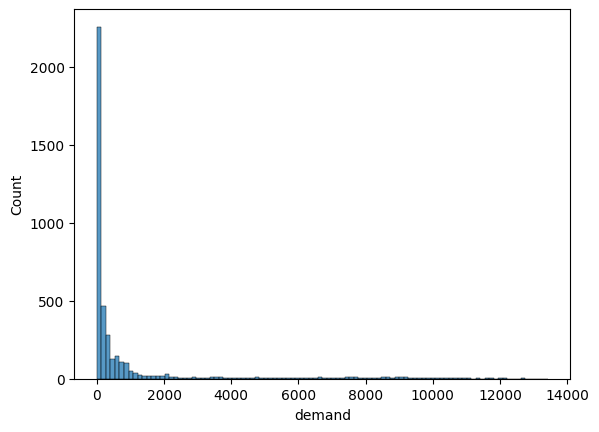

In [14]:
sns.histplot(y_test, bins=100)

If we look at the real data we can see that most taxi demands lie at lower values between 0 and 2000 and only a small fraction goes up until 14000. Therefore the model is probably a bit skewed and has a higher error.

In [15]:
print("shape all predictions", y_pred.shape)
print("shape negative predictions", y_pred[y_pred < 0].shape)
print("fraction negative predictions", (y_pred[y_pred < 0].shape[0]/y_pred.shape[0]).__round__(4)*100, "%")


shape all predictions (4112,)
shape negative predictions (253,)
fraction negative predictions 6.15 %


We can see that roughly 6% of predictions are negative, which cannot be true for a taxi demand. This is a major drawback of the SVM in comparison to other algorithms because it can also predict negative values.

## All time and location resolutions

Because we hve one feature for each hexagon via the one-hot-encoding the feature space gets very large when we increase the hexagon resolution. A SVM model uses distances between data points and features which become computationally expensive with a higher feature space. Because of this the grid search with datasets of a hexagon resolution of 7 or higher is for our computational resources too much. Therefore, we first run a grid search for the different temporal resolutions and the hexagon resolutions 5 and 6. After that we train the models with higher hexagon resolutions but sample the data to consist of only 30 hexagons and 50000 data points.

In [16]:
results = []

for time_bucket_length in [1, 2, 4, 6, 24]:
    for location_bucket in ["h3_05", "h3_06"]:

        print(f"Time bucket length: {time_bucket_length}h")
        print(f"Location bucket: {location_bucket}")

        # read in data
        data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
        print(data.shape)

        # scale data and create one hot encoding for location bucket feature
        scaled_data = scale_data_and_get_dummies(data, location_bucket)
        print(scaled_data.shape)

        # split data into train and test
        X_train, X_test, y_train, y_test = split_train_test(scaled_data)

        # run grid search for rbf kernel and save best params
        grid_result_rbf = grid_search_kernel_svr(X_train, y_train, param_grid_rbf, "rbf")
        best_params = grid_result_rbf.best_params_

        # refit on best params
        svr = SVR(kernel="rbf", **best_params)
        svr.fit(X_train, y_train)

        # evaluate metrics
        y_pred = svr.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(2)
        mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
        mse = mean_squared_error(y_test, y_pred).round(2)
        r2 = r2_score(y_test, y_pred).round(4)

        # save best params and metrics
        results.append({
            "time_bucket_length": time_bucket_length,
            "location_bucket": location_bucket,
            "rbf_svr_best_params": best_params,
            "rbf_svr_best_score": grid_result_rbf.best_score_,
            "mae": mae,
            "mape": mape,
            "mse": mse,
            "r2": r2
        })
        
        print()

Time bucket length: 1h
Location bucket: h3_05
(48690, 13)
(48690, 20)

Time bucket length: 1h
Location bucket: h3_06
(68295, 13)
(68295, 36)

Time bucket length: 2h
Location bucket: h3_05
(25264, 13)
(25264, 20)

Time bucket length: 2h
Location bucket: h3_06
(37357, 13)
(37357, 36)

Time bucket length: 4h
Location bucket: h3_05
(13052, 13)
(13052, 20)

Time bucket length: 4h
Location bucket: h3_06
(20558, 13)
(20558, 36)

Time bucket length: 6h
Location bucket: h3_05
(8736, 13)
(8736, 20)

Time bucket length: 6h
Location bucket: h3_06
(14525, 13)
(14525, 36)

Time bucket length: 24h
Location bucket: h3_05
(2193, 12)
(2193, 19)

Time bucket length: 24h
Location bucket: h3_06
(4401, 12)
(4401, 35)



In [17]:
results_df = pd.DataFrame(results)
results_df

,time_bucket_length,location_bucket,rbf_svr_best_params,rbf_svr_best_score,mae,mape,mse,r2
0,1,h3_05,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-9.633569e+04,113.68,1.04,8.816363e+04,0.8451
1,1,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-4.372723e+04,81.01,1.40,4.130345e+04,0.8639
2,2,h3_05,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-4.371722e+05,239.02,1.18,4.058679e+05,0.8181
3,2,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-2.003447e+05,158.55,1.76,1.743666e+05,0.8522
4,4,h3_05,"{'C': 100, 'epsilon': 0.1, 'gamma': 0.1}",-2.257944e+06,567.96,1.09,2.246538e+06,0.7476
5,4,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-1.028658e+06,354.65,1.61,9.781221e+05,0.7842
6,6,h3_05,"{'C': 100, 'epsilon': 0.2, 'gamma': 0.1}",-6.100041e+06,795.83,1.74,4.745244e+06,0.7159
7,6,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-2.502311e+06,511.04,2.81,2.114939e+06,0.7563
8,24,h3_05,"{'C': 100, 'epsilon': 0.1, 'gamma': 0.1}",-2.045248e+08,5791.53,0.49,1.906494e+08,0.0756
9,24,h3_06,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-7.518914e+07,2551.15,4.28,6.476704e+07,0.2126


In [18]:
results_sampled = []

for time_bucket_length in [1, 2, 4, 6, 24]:
    for location_bucket in ["h3_07", "h3_08", "h3_09"]: # higher hexagon resolutions

        print(f"Time bucket length: {time_bucket_length}h")
        print(f"Location bucket: {location_bucket}")

        # read in data
        data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
        print(data.shape)

        # create sample from data with 30 hexagons
        sampled_hexagons =  random.sample(data[location_bucket].unique().tolist(), 30) # sample data to 30 hexagons
        data_sampled = data[data[location_bucket].isin(sampled_hexagons)]
        print(data_sampled.shape)
        if data_sampled.shape[0] >= 50000: # sample data to 50000 rows
            data_sampled = data_sampled.sample(50000, random_state=4711)
            print(data_sampled.shape)

        # scale data and create one hot encoding for location bucket feature
        scaled_data = scale_data_and_get_dummies(data_sampled, location_bucket)
        print(scaled_data.shape)

        # split data into train and test
        X_train, X_test, y_train, y_test = split_train_test(scaled_data)

        # run grid search for rbf kernel and save best params
        grid_result_rbf = grid_search_kernel_svr(X_train, y_train, param_grid_rbf, "rbf")
        best_params = grid_result_rbf.best_params_

        # refit on best params
        svr = SVR(kernel="rbf", **best_params)
        svr.fit(X_train, y_train)

        # evaluate metrics
        y_pred = svr.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(2)
        mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
        mse = mean_squared_error(y_test, y_pred).round(2)
        r2 = r2_score(y_test, y_pred).round(4)

        # save best params and metrics
        results_sampled.append({
            "time_bucket_length": time_bucket_length,
            "location_bucket": location_bucket,
            "rbf_svr_best_params": best_params,
            "rbf_svr_best_score": grid_result_rbf.best_score_,
            "mae": mae,
            "mape": mape,
            "mse": mse,
            "r2": r2
        })
        
        print()

Time bucket length: 1h
Location bucket: h3_07
(163126, 13)
(37395, 13)
(37395, 42)

Time bucket length: 1h
Location bucket: h3_08
(410177, 13)
(69206, 13)
(50000, 13)
(50000, 42)

Time bucket length: 1h
Location bucket: h3_09
(571788, 13)
(34888, 13)
(34888, 42)

Time bucket length: 2h
Location bucket: h3_07
(93700, 13)
(26464, 13)
(26464, 42)

Time bucket length: 2h
Location bucket: h3_08
(245006, 13)
(37228, 13)
(37228, 42)

Time bucket length: 2h
Location bucket: h3_09
(349438, 13)
(27679, 13)
(27679, 42)

Time bucket length: 4h
Location bucket: h3_07
(54193, 13)
(20173, 13)
(20173, 42)

Time bucket length: 4h
Location bucket: h3_08
(148198, 13)
(20798, 13)
(20798, 42)

Time bucket length: 4h
Location bucket: h3_09
(216159, 13)
(8653, 13)
(8653, 42)

Time bucket length: 6h
Location bucket: h3_07
(39090, 13)
(13262, 13)
(13262, 42)

Time bucket length: 6h
Location bucket: h3_08
(109104, 13)
(14489, 13)
(14489, 42)

Time bucket length: 6h
Location bucket: h3_09
(161004, 13)
(13656, 13

In [19]:
results_sampled_df = pd.DataFrame(results_sampled)

merged_results = pd.concat([results_df, results_sampled_df])
merged_results

,time_bucket_length,location_bucket,rbf_svr_best_params,rbf_svr_best_score,mae,mape,mse,r2
0,1,h3_05,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-9.633569e+04,113.68,1.04,8.816363e+04,0.8451
1,1,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-4.372723e+04,81.01,1.40,4.130345e+04,0.8639
2,2,h3_05,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-4.371722e+05,239.02,1.18,4.058679e+05,0.8181
3,2,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-2.003447e+05,158.55,1.76,1.743666e+05,0.8522
4,4,h3_05,"{'C': 100, 'epsilon': 0.1, 'gamma': 0.1}",-2.257944e+06,567.96,1.09,2.246538e+06,0.7476
5,4,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-1.028658e+06,354.65,1.61,9.781221e+05,0.7842
6,6,h3_05,"{'C': 100, 'epsilon': 0.2, 'gamma': 0.1}",-6.100041e+06,795.83,1.74,4.745244e+06,0.7159
7,6,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-2.502311e+06,511.04,2.81,2.114939e+06,0.7563
8,24,h3_05,"{'C': 100, 'epsilon': 0.1, 'gamma': 0.1}",-2.045248e+08,5791.53,0.49,1.906494e+08,0.0756
9,24,h3_06,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-7.518914e+07,2551.15,4.28,6.476704e+07,0.2126


In [20]:
merged_results.to_csv("../../data/predictive/SVR_results_all_hex.csv", index=False)

<Axes: xlabel='time_bucket_length', ylabel='mape'>

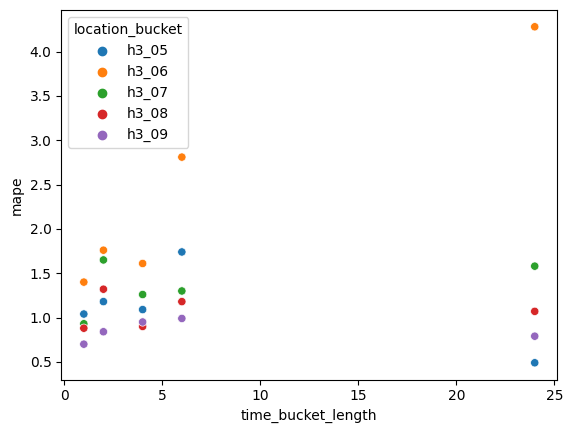

In [21]:
sns.scatterplot(x="time_bucket_length", y="mape", hue="location_bucket", data=merged_results)

## Centroid Location resolution

In [22]:
results_centroid = []

for time_bucket_length in [1, 2, 4, 6, 24]:
    for location_bucket in ["centroid"]: # higher hexagon resolutions

        print(f"Time bucket length: {time_bucket_length}h")
        print(f"Location bucket: {location_bucket}")

        # read in data
        data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
        print(data.shape)

        # create sample from data with 30 hexagons
        sampled_hexagons =  random.sample(data[location_bucket].unique().tolist(), 30) # sample data to 30 hexagons
        data_sampled = data[data[location_bucket].isin(sampled_hexagons)]
        print(data_sampled.shape)
        if data_sampled.shape[0] >= 50000: # sample data to 50000 rows
            data_sampled = data_sampled.sample(50000, random_state=4711)
            print(data_sampled.shape)

        # scale data and create one hot encoding for location bucket feature
        scaled_data = scale_data_and_get_dummies(data_sampled, location_bucket)
        print(scaled_data.shape)

        # split data into train and test
        X_train, X_test, y_train, y_test = split_train_test(scaled_data)

        # run grid search for rbf kernel and save best params
        grid_result_rbf = grid_search_kernel_svr(X_train, y_train, param_grid_rbf, "rbf")
        best_params = grid_result_rbf.best_params_

        # refit on best params
        svr = SVR(kernel="rbf", **best_params)
        svr.fit(X_train, y_train)

        # evaluate metrics
        y_pred = svr.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(2)
        mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
        mse = mean_squared_error(y_test, y_pred).round(2)
        r2 = r2_score(y_test, y_pred).round(4)

        # save best params and metrics
        results_centroid.append({
            "time_bucket_length": time_bucket_length,
            "location_bucket": location_bucket,
            "rbf_svr_best_params": best_params,
            "rbf_svr_best_score": grid_result_rbf.best_score_,
            "mae": mae,
            "mape": mape,
            "mse": mse,
            "r2": r2
        })
        
        print()

Time bucket length: 1h
Location bucket: centroid
(584995, 8)
(56484, 8)
(50000, 8)
(50000, 36)

Time bucket length: 2h
Location bucket: centroid
(357489, 8)
(21099, 8)
(21099, 37)

Time bucket length: 4h
Location bucket: centroid
(221146, 8)
(13310, 8)
(13310, 37)

Time bucket length: 6h
Location bucket: centroid
(164645, 8)
(10057, 8)
(10057, 37)

Time bucket length: 24h
Location bucket: centroid
(63605, 7)
(3218, 7)
(3218, 36)



In [23]:
pd.DataFrame(results_centroid)

,time_bucket_length,location_bucket,rbf_svr_best_params,rbf_svr_best_score,mae,mape,mse,r2
0,1,centroid,"{'C': 100, 'epsilon': 0.5, 'gamma': 'scale'}",-195.958089,7.59,0.75,190.77,0.8071
1,2,centroid,"{'C': 100, 'epsilon': 0.5, 'gamma': 'scale'}",-293.323761,7.62,1.04,283.07,0.5567
2,4,centroid,"{'C': 100, 'epsilon': 0.5, 'gamma': 'scale'}",-9248.637920,43.83,1.46,9134.94,0.8956
3,6,centroid,"{'C': 100, 'epsilon': 0.5, 'gamma': 'scale'}",-4602.902688,27.41,1.06,4382.78,0.8516
4,24,centroid,"{'C': 100, 'epsilon': 0.5, 'gamma': 'scale'}",-9447.337539,35.29,1.00,9808.54,0.8474


In [27]:
merged_results = pd.concat([merged_results, pd.DataFrame(results_centroid)])
merged_results

,time_bucket_length,location_bucket,rbf_svr_best_params,rbf_svr_best_score,mae,mape,mse,r2
0,1,h3_05,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-9.633569e+04,113.68,1.04,8.816363e+04,0.8451
1,1,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-4.372723e+04,81.01,1.40,4.130345e+04,0.8639
2,2,h3_05,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-4.371722e+05,239.02,1.18,4.058679e+05,0.8181
3,2,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-2.003447e+05,158.55,1.76,1.743666e+05,0.8522
4,4,h3_05,"{'C': 100, 'epsilon': 0.1, 'gamma': 0.1}",-2.257944e+06,567.96,1.09,2.246538e+06,0.7476
5,4,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-1.028658e+06,354.65,1.61,9.781221e+05,0.7842
6,6,h3_05,"{'C': 100, 'epsilon': 0.2, 'gamma': 0.1}",-6.100041e+06,795.83,1.74,4.745244e+06,0.7159
7,6,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-2.502311e+06,511.04,2.81,2.114939e+06,0.7563
8,24,h3_05,"{'C': 100, 'epsilon': 0.1, 'gamma': 0.1}",-2.045248e+08,5791.53,0.49,1.906494e+08,0.0756
9,24,h3_06,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-7.518914e+07,2551.15,4.28,6.476704e+07,0.2126


In [28]:
merged_results.to_csv("../../data/predictive/SVR_results_all.csv", index=False)

<Axes: xlabel='time_bucket_length', ylabel='mape'>

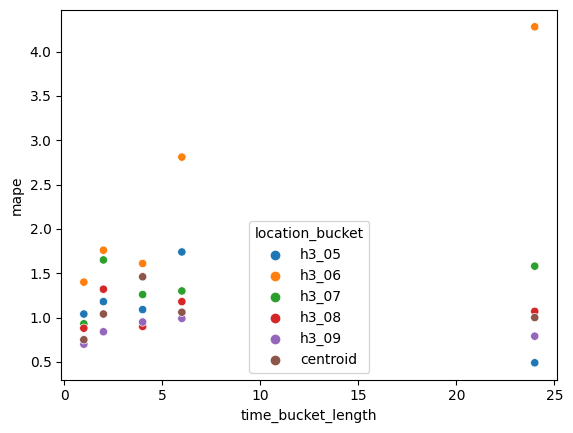

In [29]:
sns.scatterplot(x="time_bucket_length", y="mape", hue="location_bucket", data=merged_results)

Because we think that predicting taxi demand on a daily basis is not specific enough because there are fluctuations in the taxidemand over the day, we plot the MAPE values for the time bucktes up until 6.

<Axes: xlabel='time_bucket_length', ylabel='mape'>

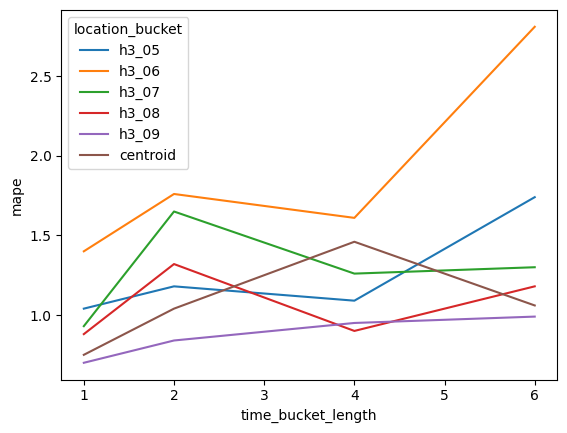

In [33]:
sns.lineplot(x="time_bucket_length", y="mape", hue="location_bucket", data=merged_results[(merged_results["time_bucket_length"] < 24)])

We can see that the mean absolute percentage error is the highest for the hexagon length 6. For all time resolutions the hexagon resoltion 9 has the smallest percentage error except for the time bucket 4. Here a H3 resolution of 8 performs slightly better. We think that a hexagon resolution of 8 (length 461m) and the time bucket 4 hours are the best ones for predicting taxi demand as a resolution of 9 (174m) is a very small discretization and a driver can easily and fast drive a 461m distance. Furthermore, a time resolution of 4 seems to be a good fit because it covers 6 time blocks a day where different demand can be observed. Therefore we refit the model with the best parameters of H3 8 and time bucket length 4 again to evaluate the final model.

## Final Model

Bestes model bei time bucket ....

In [34]:
time_bucket_length = 4
location_bucket = "h3_08"

In [35]:
# read in data
data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
print(data.shape)

# create sample from data with 10 hexagons
#sampled_hexagons =  random.sample(data[location_bucket].unique().tolist(), 10)
#data_sampled = data[data[location_bucket].isin(sampled_hexagons)]
#print(data_sampled.shape)
#if data_sampled.shape[0] >= 10000:
#    data_sampled = data_sampled.sample(10000, random_state=4711)
#    print(data_sampled.shape)

# scale data and create one hot encoding for location bucket feature
scaled_data = scale_data_and_get_dummies(data, location_bucket)
print(scaled_data.shape)

# split data into train and test
X_train, X_test, y_train, y_test = split_train_test(scaled_data)

(148198, 13)
(148198, 310)


In [36]:
# train model
fin_model = SVR(C=100, epsilon=0.5, gamma=0.1, kernel="rbf")
fin_model.fit(X_train, y_train)

In [ ]:
# evaluate model
y_pred = fin_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred).round(2)
mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
mse = mean_squared_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(4)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"R2: {r2}"